# OCDFG Streaming Discovery with OCOperator

This guide demonstrates how to use the `OCOperator` for real-time, object-centric process discovery in streaming settings. It supports dynamic registration, object filtering, relationship mining, and model merging using configurable strategies.

---

## OCOperator Overview

### Factory Function

Use `oc_operator(...)` to instantiate a configured streaming operator.

```python
op = oc_operator(
    strategy_handler=RelativeFrequencyBasedStrategy(...),
    control_flow={"Order": lambda: heuristics_miner_lossy_counting(...)},
    aer_model_update_frequency=30,
    aer_model_max_approx_error=0.01
)
```

---

## Factory Parameters

### 1. `strategy_handler: Optional[EmissionStrategy]`

Controls how and when object types are **registered** or **deregistered**. Supported strategies include:

* `RelativeFrequencyBasedStrategy(threshold: float)`
* `LossyCountingStrategy(max_approx_error: float)`
* `SlidingWindowActivityStrategy(window_size: int)`

> If omitted, `RelativeFrequencyBasedStrategy(0.05)` is used by default.

---

### 2. `control_flow: Optional[Dict[str, Callable[[], StreamMiner]]]`

A dictionary mapping object types to miner factories (callables returning stream miners).

* If `None` or empty, the operator runs in **dynamic mode**, creating miners on-the-fly.
* If set, only the specified object types are monitored with explicitly assigned miners.

---

### 3. `aer_model_update_frequency: int = 30`

Number of `BOEvent`s between emissions of updated Activity-Entity Relationship (AER) diagrams.

---

### 4. `aer_model_max_approx_error: float = 0.01`

Used to apply lossy counting to object-relationship mining. Smaller values reduce approximation error.

---

## Operator Architecture

### Per-Object-Type Streams

* Each object type (e.g., `Order`, `Item`) gets its own miner stream.
* Miners are either preconfigured or created dynamically.

### AER Relationship Stream

* One stream processes full `BOEvent`s to discover object-activity and object-object relationships.
* Emissions occur at a fixed interval with lossy counting.

### Emission Strategy Integration

* Emission strategies control when to emit `REGISTER` and `DEREGISTER` commands.
* These strategies observe the stream and decide based on frequency or recency.

---

## Output Schema

The output of the operator is an `Observable[dict]` with entries like:

```python
{
  "type": "model" | "aer_diagram" | "command",
  "object_type": str,          # only for model/command
  "model": HeuristicsNet | ActivityERDiagram,
  "command": Command.REGISTER | Command.DEREGISTER  # only for command type
}
```

---

## Merging Output with `oc_merge_operator`

The operator output can be passed to `oc_merge_operator()` to combine all active models into a single `OCDFG`.

```python
from pybeamline.algorithms.oc.ocdfg_merge_operator import oc_merge_operator

op = oc_operator(...)
merged = oc_merge_operator()

boevent_stream.pipe(op, merged).subscribe(print)
```

### Merged Output Schema

```python
{
  "ocdfg": OCDFG,
  "aer_diagram": ActivityERDiagram
}
```

The merged result keeps only the currently registered object types.

---

## Complete Example

```python
from pybeamline.algorithms.discovery.heuristics_miner_lossy_counting import heuristics_miner_lossy_counting
from pybeamline.algorithms.oc.strategies.base import RelativeFrequencyBasedStrategy
from pybeamline.algorithms.oc.oc_operator import oc_operator
from pybeamline.algorithms.oc.ocdfg_merge_operator import oc_merge_operator

# Define strategy
strategy = RelativeFrequencyBasedStrategy(frequency_threshold=0.05)

# Define control flow with specific miners for each object type, which can have different configurations
# If None, dynamic discovery is used and all object types are monitored with the default: heuristics_miner_lossy_counting(10)
control_flow = {
        "Order": lambda: heuristics_miner_lossy_counting(model_update_frequency=10, max_approx_error=0.01),
        "Item": lambda: heuristics_miner_lossy_counting_budget(model_update_frequency=10, budget=100) # Different miner for Item
    }

boevent_stream.pipe(
    oc_operator(inclusion_strategy=strategy,
                control_flow=control_flow,
                aer_model_update_frequency=20,
                aer_model_max_approx_error=0.01),
    oc_merge_operator()
).subscribe(print)
```

This pattern can be used in evaluation, real-time dashboards, or experimental setups.


# OCOperator in Action

The following scripts will showcase some of the features of the OCOperator

In [27]:
# Imports
import importlib
from typing import Tuple, Dict

# Third-party libraries
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pm4py import read_ocel2
from pm4py.algo.discovery.ocel.ocdfg import algorithm as ocdfg_discovery

# PyBeamline components
import pybeamline
from pybeamline.boevent import BOEvent
from pybeamline.models.ocdfg import OCDFG
from pybeamline.sources.ocel2_log_source_from_file import ocel2_log_source_from_file
from pybeamline.sources.dict_ocel_test_source import dict_test_ocel_source
from pybeamline.algorithms.oc.oc_operator import oc_operator
from pybeamline.algorithms.oc.oc_merge_operator import oc_merge_operator
from pybeamline.algorithms.oc.strategies.base import RelativeFrequencyBasedStrategy, LossyCountingStrategy, SlidingWindowStrategy
from pybeamline.algorithms.discovery.heuristics_miner_lossy_counting import heuristics_miner_lossy_counting

# Optional: Reload PyBeamline if actively developing
importlib.reload(pybeamline)

<module 'pybeamline' from 'C:\\Users\\jepmi\\Desktop\\Github\\pybeamline-OCPM\\pybeamline\\__init__.py'>

In [7]:
# Build a source from dict
dict_source = [
        {"activity": "Register Customer", "objects": {"Customer": ["c1"]}},
        {"activity": "Create Order", "objects": {"Customer": ["c1"], "Order": ["o1"]}},
        {"activity": "Add Item", "objects": {"Order": ["o1"], "Item": ["i1"]}},
        {"activity": "Add Item", "objects": {"Order": ["o1"], "Item": ["i2"]}},
        {"activity": "Reserve Item", "objects": {"Item": ["i1"]}},
        {"activity": "Pack Item", "objects": {"Item": ["i1","i2"], "Order": ["o1"]}},
        {"activity": "Ship Item", "objects": {"Item": ["i1","i2"], "Shipment": ["s1"]}},
        {"activity": "Send Invoice", "objects": {"Order": ["o1"], "Invoice": ["inv1"]}},
        {"activity": "Receive Review", "objects": {"Customer": ["c1"], "Order": ["o1"]}},
        ]

source = dict_test_ocel_source([(dict_source,10)])

source.pipe(
).subscribe(print)


{'ocel:eid': 'e0', 'ocel:activity': 'Register Customer', 'ocel:timestamp': datetime.datetime(2025, 6, 9, 21, 59, 57, 818467), 'ocel:omap': {'Customer': {'c1_0'}}, 'ocel:vmap': {}}
{'ocel:eid': 'e1', 'ocel:activity': 'Create Order', 'ocel:timestamp': datetime.datetime(2025, 6, 9, 21, 59, 57, 818467), 'ocel:omap': {'Customer': {'c1_0'}, 'Order': {'o1_0'}}, 'ocel:vmap': {}}
{'ocel:eid': 'e2', 'ocel:activity': 'Add Item', 'ocel:timestamp': datetime.datetime(2025, 6, 9, 21, 59, 57, 818467), 'ocel:omap': {'Order': {'o1_0'}, 'Item': {'i1_0'}}, 'ocel:vmap': {}}
{'ocel:eid': 'e3', 'ocel:activity': 'Add Item', 'ocel:timestamp': datetime.datetime(2025, 6, 9, 21, 59, 57, 818467), 'ocel:omap': {'Order': {'o1_0'}, 'Item': {'i2_0'}}, 'ocel:vmap': {}}
{'ocel:eid': 'e4', 'ocel:activity': 'Reserve Item', 'ocel:timestamp': datetime.datetime(2025, 6, 9, 21, 59, 57, 818467), 'ocel:omap': {'Item': {'i1_0'}}, 'ocel:vmap': {}}
{'ocel:eid': 'e5', 'ocel:activity': 'Pack Item', 'ocel:timestamp': datetime.datetim

## Default initialisation

As shown earlier the *default* behavior of `oc_operator` is based on dynamic discovery, in which all Object-Type Stream Miners are set to `heuristics_lossy_counting(10)`, and

In [22]:

# Helper functions
# Path to the OCEL2 log file
log_path = '../../tests/logistics.jsonocel'

# PM4Py
def read_ocel2_log(filename: str):
    return read_ocel2(filename)

# Load the OCEL log
oc_event_log = read_ocel2_log(log_path)


# Do OCDFG static discovery
ocdfg = ocdfg_discovery.apply(oc_event_log)
def conform_ocdfg(ocdfg_pm4py) -> set[Tuple[str, str, str]]:
    """
    Convert PM4Py OCDFG to a set of edges in the format (source, object_type, target).
    """
    result = set()
    for obj_type in ocdfg_pm4py["edges"]["event_couples"].keys():
        for src, tgt in ocdfg_pm4py["edges"]["event_couples"][obj_type].keys():
            result.add((src, obj_type, tgt))
    return result
# Convert the PM4Py OCDFG to a set of edges
ocdfg_edges_pm4py = conform_ocdfg(ocdfg)


# Create source from file
source = ocel2_log_source_from_file(log_path)

# Set based jaccard similarity function
def jaccard_similarity(model: set, ref_model: set) -> float:
    intersection = model.intersection(ref_model)
    #if intersection is not None:
    #    print(f"The missing edges in the model: {ref_model - intersection}")
    intersection = len(model.intersection(ref_model))
    union = len(model.union(ref_model))

    if union == 0:
        return 0.0
    return intersection / union

# Conform the emitted OCDFGs to the set notation of edges
def conform_emit_ocdfg(ocdfg: OCDFG) -> set[Tuple[str, str, str]]:
    """
    Convert OCDFG to a set of edges in the format (source, object_type, target).
    """
    result = set()
    for obj_type, transitions in ocdfg.edges.items():
        for (src, tgt), freq in transitions.items():
            result.add((src, obj_type, tgt))
    return result



emitted_ocdfgs = []
def append_ocdfg(output):
    global emitted_ocdfgs
    emitted_ocdfgs.append(output["ocdfg"])


def egdes_pr_object_type(ocdfg: set[Tuple[str,str,str]]) -> Dict[str, set[Tuple[str, str, str]]]:
    """
    Convert OCDFG to a dictionary of edges per object type.
    """
    result = {}
    for src, obj_type, tgt in ocdfg:
        if obj_type not in result:
            result[obj_type] = set()
        result[obj_type].add((src,obj_type, tgt))
    return result


def plot_jaccard(df: pd.DataFrame, title: str, hue: str = None):
    plt.figure(figsize=(12, 5))
    if hue is not None:
        sns.lineplot(data=df, x="Snapshot", y="Jaccard Similarity", hue=hue)
    else:
        sns.lineplot(data=df, x="Snapshot", y="Jaccard Similarity")
    plt.title(title)
    plt.xlabel("Snapshot Index")
    plt.ylabel("Jaccard Similarity")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


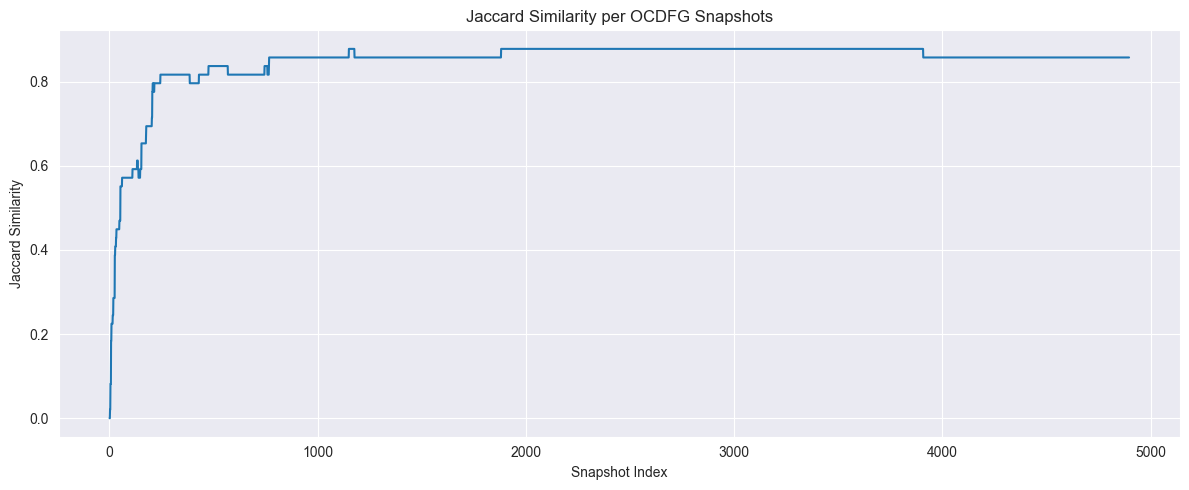

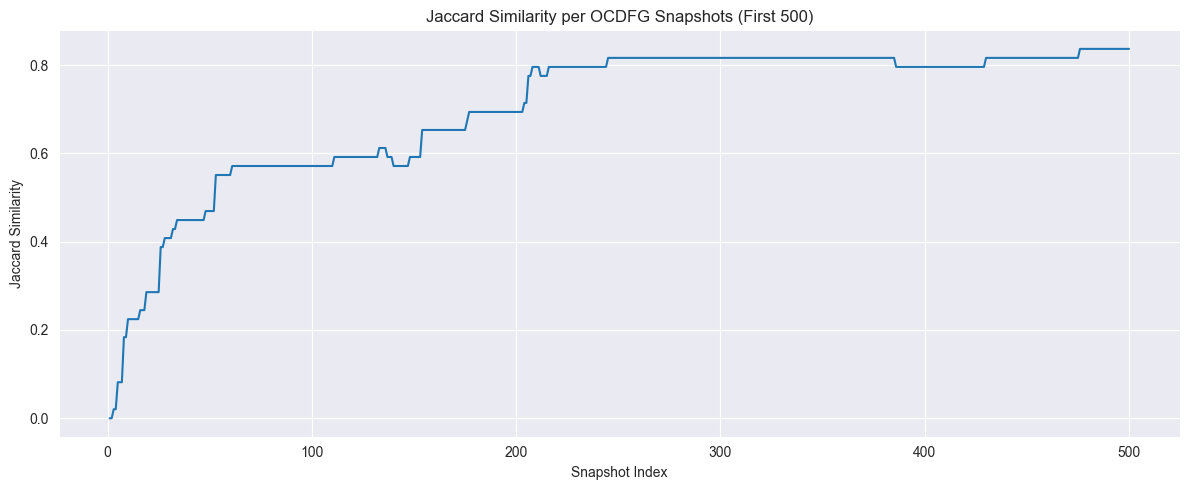

In [23]:


# Streaming of Object-Centric Process Mining

source.pipe(
    oc_operator(inclusion_strategy=RelativeFrequencyBasedStrategy(frequency_threshold=0.0001)),
    oc_merge_operator()
).subscribe(append_ocdfg)

# Conform to set-based ocdfg
emitted_ocdfgs_edge_set = [ conform_emit_ocdfg(ocdfg) for ocdfg in emitted_ocdfgs]

jacc_similarities = []
for ocdfg_edge_set in emitted_ocdfgs_edge_set:
    similarity = jaccard_similarity(ocdfg_edge_set, ocdfg_edges_pm4py)
    jacc_similarities.append(similarity)


# Create a DataFrame for Seaborn
df = pd.DataFrame({
    "Snapshot": range(1, len(jacc_similarities) + 1),
    "Jaccard Similarity": jacc_similarities
})

plot_jaccard(df, "Jaccard Similarity per OCDFG Snapshots")

jacc_sim_slice = jacc_similarities[:500]  # Display the first 500 similarities for brevity
df_slice = pd.DataFrame({
    "Snapshot": range(1, len(jacc_sim_slice) + 1),
    "Jaccard Similarity": jacc_sim_slice
})

plot_jaccard(df_slice, "Jaccard Similarity per OCDFG Snapshots (First 500)")


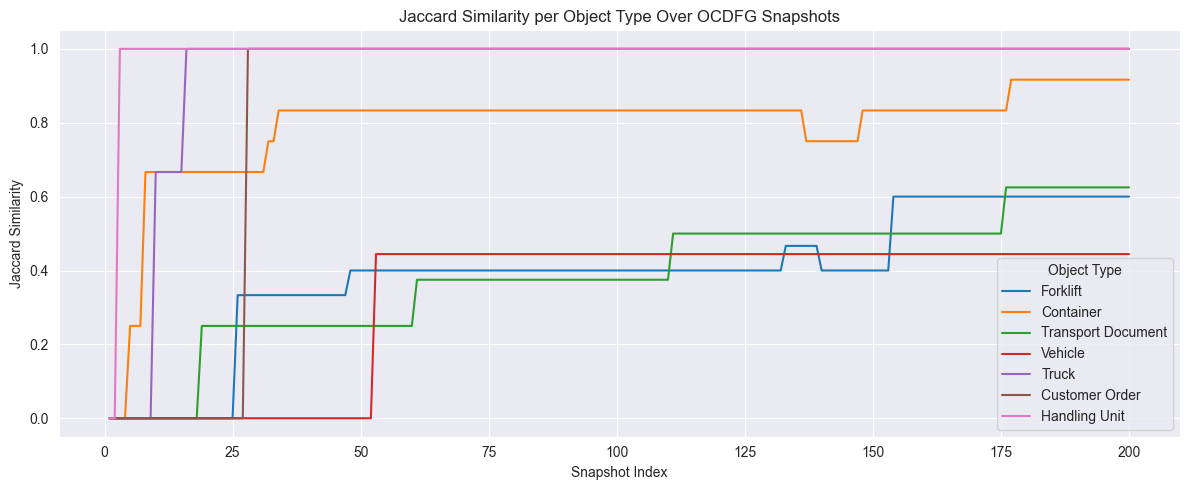

In [24]:

# Convert the PM4Py OCDFG edges to a dictionary of edges per object type
ocdfg_edges_per_object_type = egdes_pr_object_type(ocdfg_edges_pm4py)

emitted_ocdfgs_edge_set = [ conform_emit_ocdfg(ocdfg) for ocdfg in emitted_ocdfgs]

obj_type_jacc_similarities = {}

for snapshot in emitted_ocdfgs_edge_set:
    snapshot_per_obj = egdes_pr_object_type(snapshot)

    for obj_type, ref_edges in ocdfg_edges_per_object_type.items():
        # Initialize list if first time
        if obj_type not in obj_type_jacc_similarities:
            obj_type_jacc_similarities[obj_type] = []

        model_edges = snapshot_per_obj.get(obj_type, set())
        similarity = jaccard_similarity(model_edges, ref_edges)
        obj_type_jacc_similarities[obj_type].append(similarity)

records = []

for obj_type, similarities in obj_type_jacc_similarities.items():
    for i, sim in enumerate(similarities[:200], start=1):
        records.append({
            "Snapshot": i,
            "Object Type": obj_type,
            "Jaccard Similarity": sim
        })

df_long = pd.DataFrame(records)

plot_jaccard(df_long, "Jaccard Similarity per Object Type Over OCDFG Snapshots", hue="Object Type")



# Concept Drift

The following script demonstrates how the OCOperator can handle concept drift by dynamically registering new object types and miners.


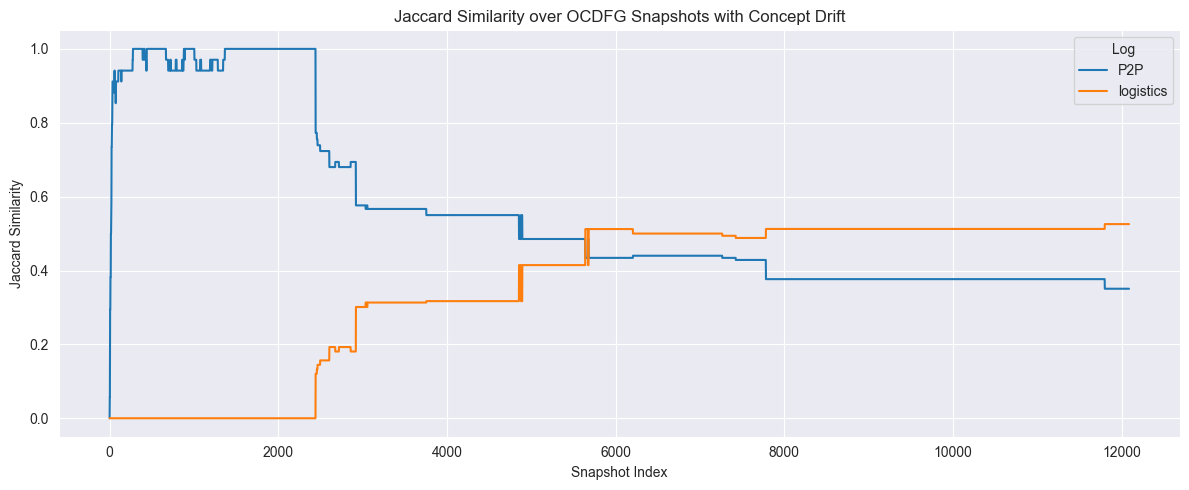

In [25]:
log_path2 = '../../tests/ocel2-p2p.json'
source = ocel2_log_source_from_file(log_path)
source2 = ocel2_log_source_from_file(log_path2)

# Process new log
# Load the OCEL log
# Do OCDFG static
oc_event_log = read_ocel2_log(log_path2)
ocdfg_p2p = ocdfg_discovery.apply(oc_event_log)
ocdfg_edges_p2p_pm4py = conform_ocdfg(ocdfg_p2p)


# Concatenate the two sources
from reactivex import concat
from reactivex import operators as ops
new_source = concat(source2,source)
new_source = concat(new_source, source)


emitted_ocdfgs = []
new_source.pipe(
    oc_operator(inclusion_strategy=RelativeFrequencyBasedStrategy(frequency_threshold=0.02)),
    oc_merge_operator()
).subscribe(lambda x: emitted_ocdfgs.append(x["ocdfg"]))

# Conform to set-based ocdfg
emitted_ocdfgs_edge_set = [ conform_emit_ocdfg(ocdfg) for ocdfg in emitted_ocdfgs]

jacc_similarities = []
for i, ocdfg_edge_set in enumerate(emitted_ocdfgs_edge_set, start=1):
    similarity_p2p = jaccard_similarity(ocdfg_edge_set, ocdfg_edges_p2p_pm4py)
    similarity_logistics = jaccard_similarity(ocdfg_edge_set, ocdfg_edges_pm4py)
    jacc_similarities.append({
        "snapshot": len(jacc_similarities) + 1,
        "p2p": similarity_p2p,
        "logistics": similarity_logistics
    })


df_long = pd.DataFrame([
    {"Snapshot": sim["snapshot"], "Log": "P2P", "Jaccard Similarity": sim["p2p"]}
    for sim in jacc_similarities
] + [
    {"Snapshot": sim["snapshot"], "Log": "logistics", "Jaccard Similarity": sim["logistics"]}
    for sim in jacc_similarities
])


plot_jaccard(df_long, "Jaccard Similarity over OCDFG Snapshots with Concept Drift", hue="Log")


## Concept drift with Lossy Counting

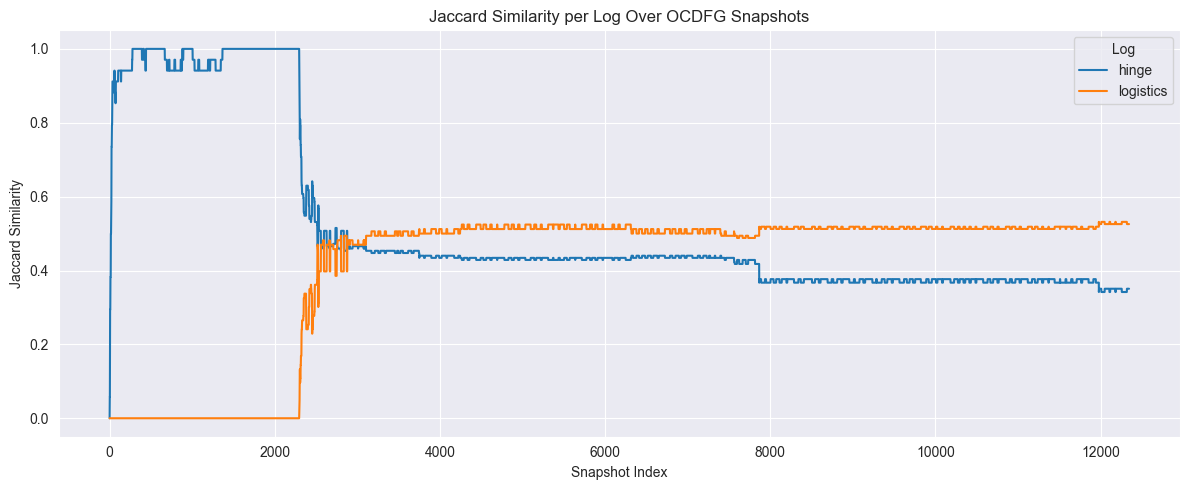

In [13]:
emitted_ocdfgs = []
new_source.pipe(
    oc_operator(inclusion_strategy=LossyCountingStrategy(max_approx_error=0.02)),
    oc_merge_operator()
).subscribe(lambda x: emitted_ocdfgs.append(x["ocdfg"]))

# Conform to set-based ocdfg
emitted_ocdfgs_edge_set = [ conform_emit_ocdfg(ocdfg) for ocdfg in emitted_ocdfgs]

jacc_similarities = []
for i, ocdfg_edge_set in enumerate(emitted_ocdfgs_edge_set, start=1):
    similarity_p2p = jaccard_similarity(ocdfg_edge_set, ocdfg_edges_p2p_pm4py)
    similarity_logistics = jaccard_similarity(ocdfg_edge_set, ocdfg_edges_pm4py)
    jacc_similarities.append({
        "snapshot": len(jacc_similarities) + 1,
        "p2p": similarity_p2p,
        "logistics": similarity_logistics
    })


df_long = pd.DataFrame([
    {"Snapshot": sim["snapshot"], "Log": "p2p", "Jaccard Similarity": sim["p2p"]}
    for sim in jacc_similarities
] + [
    {"Snapshot": sim["snapshot"], "Log": "logistics", "Jaccard Similarity": sim["logistics"]}
    for sim in jacc_similarities
])

plot_jaccard(df_long, "Jaccard Similarity per Log Over OCDFG Snapshots with Lossy Counting", hue="Log")

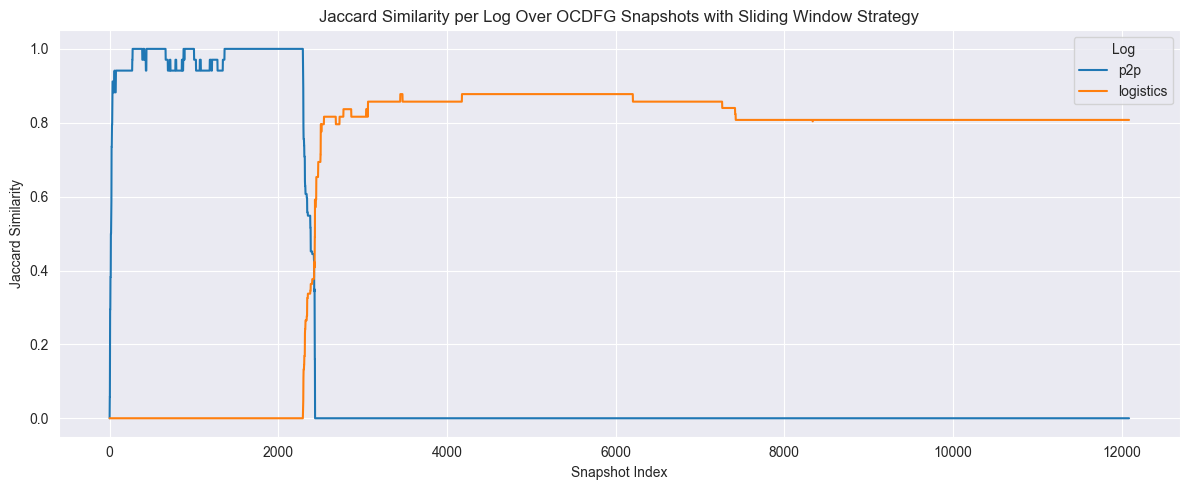

In [28]:
emitted_ocdfgs = []
new_source.pipe(
    oc_operator(inclusion_strategy=SlidingWindowStrategy(window_size=100)),
    oc_merge_operator()
).subscribe(lambda x: emitted_ocdfgs.append(x["ocdfg"]))

# Conform to set-based ocdfg
emitted_ocdfgs_edge_set = [ conform_emit_ocdfg(ocdfg) for ocdfg in emitted_ocdfgs]

jacc_similarities = []
for i, ocdfg_edge_set in enumerate(emitted_ocdfgs_edge_set, start=1):
    similarity_p2p = jaccard_similarity(ocdfg_edge_set, ocdfg_edges_p2p_pm4py)
    similarity_logistics = jaccard_similarity(ocdfg_edge_set, ocdfg_edges_pm4py)
    jacc_similarities.append({
        "snapshot": len(jacc_similarities) + 1,
        "p2p": similarity_p2p,
        "logistics": similarity_logistics
    })


df_long = pd.DataFrame([
    {"Snapshot": sim["snapshot"], "Log": "p2p", "Jaccard Similarity": sim["p2p"]}
    for sim in jacc_similarities
] + [
    {"Snapshot": sim["snapshot"], "Log": "logistics", "Jaccard Similarity": sim["logistics"]}
    for sim in jacc_similarities
])

plot_jaccard(df_long, "Jaccard Similarity per Log Over OCDFG Snapshots with Sliding Window Strategy", hue="Log")
